<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0318_Ensemble%2CBagging%2CBoosting%2CRF%2CVoting%2CAda%2CXGB_HandsOnML_245_271.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 학습과 랜덤 포레스트
- 앙상블 학습: 일련의 예측기(**앙상블**)로부터 예측을 수집하여 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다
- 앙상블 방법: 앙상블 학습 알고리즘
- 앙상블의 예: 랜덤 포레스트


## 7.1 투표기반 분류기
- 직접투표: 각 분류기의 예측을 모아 가장 많이 선택된 클래스를(다수결) 예측하는 것.
- 각 분류기가 **약한 학습기**일지라도 충분히 많고 다양하다면 앙상블은 **강한 학습기**가 될 수 있다
- **큰수의 법칙**에 의해 클래스 수가 적으면 정확한 분류를 할 가능성이 높아진다. (가정: 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없을 때)
- 하지만 실제로 모델은 같은 데이터로 훈련시키므로 이러한 가정은 맞지 않는다. 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많으며 앙상블의 정확도가 낮아진다.
- 다음은 VotingClassifier를 만들고 훈련시키는 코드이다.


In [42]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf),('rf',rnd_clf), ('svc', svm_clf)], voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

- 각 분류기의 테스트셋 정확도를 알아보자

In [44]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.9
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


- 투표기반 분류기가 다른 분류기들보다 성능이 좀더 높은 편이다.
- 모든 분류기가 클래스의 확률을 예측할 수 있으면(predict_proba()메서드가 있으면) 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측할 수 있다. 이를 **간접투표**라고 한다. 이를 사용할 때 voting ="soft"로 바꾸면 된다.
- SVC는 기본값에서는 클래스 확률을 제공하지 않으므로  probability 매개변수를 True로 지정해야 한다. 이렇게 하면 클래스 확률을 측정하기 위해 교차 검증을 사용하므로 훈련 속도가 느려지지만 SVC에서 predict_proba()매서드를 사용할 수 있다.

## 7.2. 배깅과 페이스팅
- **배깅** (bootsrap aggregating): 훈련세트에서 중복을 허용하여 샘플링하는 방식
- **페이스팅** : 중복을 허용하지 않고 샘플링하는 방식
- 배깅과 페이스팅에서는 같은 훈련 샘플을 여러개의 예측기에 걸쳐 사용할 수 있다. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다.
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 수집함수는 전형적으로 **분류일 때는 통계적 최빈값(다수결)**이고 **회귀에 대해서는 평균**을 계산한다.
- 개별 예측기는 원본 훈련세트로 훈련시킨 것보다 훨씬 편향되어 있지만 수집함수를 통과하면 편향과 분산이 감소된다. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.
- 예측기는 모두 동시에 다른 CPU코어나 서버에서 병렬로 학습시킬 수 있다. 이와 유사하게 예측도 병렬로 수행할 수 있다. 이런 확장성 덕분에 배깅과 페이스팅의 인기가 높습니다.

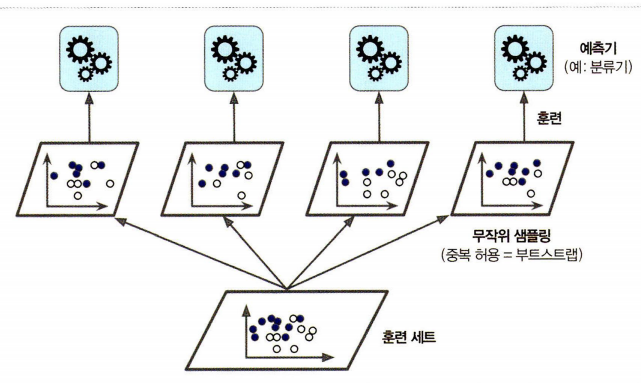

### 7.2.1 사이킷런의 배깅과 페이스팅
- 다음은 결정트리분류기 500개의 앙상블을 훈련시키는 코드이다
- 페이스팅 사용 시 bootstrap=False로 지정하면 된다.
- n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU코어 수를 지정한다. -1로 지정 시 가용한 모든 코어를 사용한다.

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1
    )
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

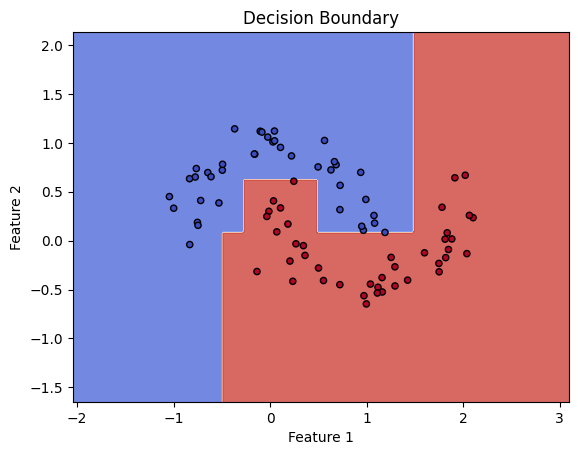

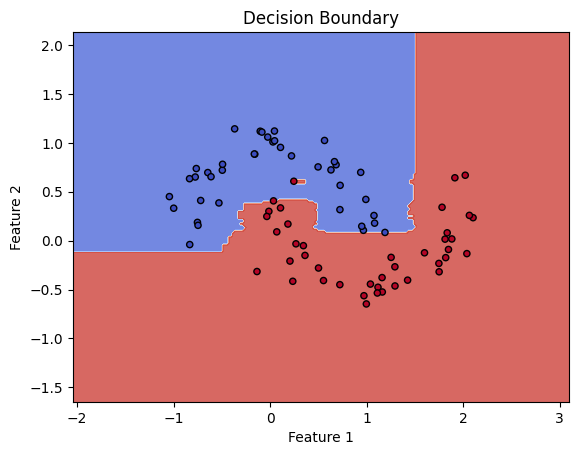

In [46]:
import matplotlib.pyplot as plt
def plot_decision_boundary(model, X, y):
    h = 0.02  # Mesh의 단위 크기
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()


dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)
plot_decision_boundary(dt_clf, X_train, y_train)
plot_decision_boundary(bag_clf, X_train, y_train)

- 단일 결정 트리의 경계보다 500개의 트리를 사용한 배깅 앙상블의 결정 경계가 더 일반화가 잘 됨을 알 수 있다.
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 주이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호된다. 그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋다.

### 7.2.2. oob 평가
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다.
- BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap=True) 훈련 세트의 크기만큼인 m개 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다. 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag)샘플이라고 부른다. 예측기마다 남겨진 37%는 모두 다르다.
- 예측기가 훈련되는 동안에는 oob샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob샘플을 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻는다.
- 사이킷런에서 BaggingClassfier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다. 평가점수결과는 oob_score_ 변수에 저장되어 있다.

In [52]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.95

- oob 결과를 살펴보면 이 BaggingClassifier는 테스트 데이터 세트에서 약 90.1%의 정확도를 얻을 것으로 보인다. 이를 확인해보겠다

In [53]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

1.0

- 테스트 세트에서의 정확도와 비슷하다
- oob 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인할 수 있다. 이 경우 결정함수는 각 훈련 샘플의 클래스 확률을 반환한다.

In [54]:
bag_clf.oob_decision_function_

array([[0.36571429, 0.63428571],
       [0.65979381, 0.34020619],
       [0.        , 1.        ],
       [0.96335079, 0.03664921],
       [1.        , 0.        ],
       [0.99404762, 0.00595238],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.99418605, 0.00581395],
       [0.        , 1.        ],
       [0.18435754, 0.81564246],
       [0.90710383, 0.09289617],
       [0.00502513, 0.99497487],
       [0.92893401, 0.07106599],
       [0.        , 1.        ],
       [0.99456522, 0.00543478],
       [0.97560976, 0.02439024],
       [0.25490196, 0.74509804],
       [0.        , 1.        ],
       [0.87845304, 0.12154696],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64534884, 0.35465116],
       [0.9902439 , 0.0097561 ],
       [0.00995025, 0.99004975],
       [0.00561798, 0.99438202],
       [0.32460733, 0.67539267],
       [0.05319149, 0.94680851],
       [0.88297872, 0.11702128],
       [0.

## 7.3 핸덤 패치와 랜덤 서브스페이스
- BaggingClassifier는 특성 샘플링도 지원한다. 샘플링은 max_features, bootstrap_featues 2개의 매개변수로 조절된다. 작동방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다. 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.
- 이 기법은 이미지와 같은 고차원의 데이터셋을 다룰 때 유용하다
- 랜덤패치방식(random patches method) : 훈련 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식 (random subspace method) : 훈련 샘플을 모두 사용하고(bootstrap=False 이고 max_sample=1.0 으로 설정) 특성은 샘플링하는 것(bootstrap=True 그리고/또는 max_sample=1.0 보다 작게 설정)을 랜덤 서브스페이스 방식이라고 한다.
- 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춘다.

7.4 랜덤 포레스트
랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블이다. 전형적으로 max_sample를 훈련세트의 크기로 지정한다. bagging에 decisiontree를 넣어 만드는 대신 결정트레에 최적화되어 사용하기 편한 RandomForestClassifier를 사용할 수 있다. 다음은 500개의 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU코어에서 훈련시키는 코드이다.

In [56]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators= 500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train,y_train)

y_pred = rnd_clf.predict(X_test)

- RandomForestClassifier는 DecisionTreeClassiifer와 BaggingClassifier의 매개변수를 모두 가지고 있다
- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 즉성을 찾는 대신 무작위로 선택한 특성후보중에서 최적의 특성을 찾는 식으로 무작위성을 한번 더 주입한다. 이는 트릴를 더 다양하게 만들고 편향을 다시한번 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다.
- 다음은 Bagging을 사용해 RandomForest와 거의 유사하게 만든 것이다.

In [62]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16), n_estimators=500, max_samples=1, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리
- 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용합니다. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다.
- 이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리 앙상블**(또는 줄여서 **엑스트라 트리**)라고 부른다. 여기서도 편향이 늘어나지만 분산이 낮추게 된다. 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다
- 엑스트라 트리를 만들려면 사이킷런의 ExtraTreeClassifier를 사용한다. 사용법은 RandomForestClassifier와 같다.

### 7.4.2 특성 중요도
- 랜덤 포레스트의 또다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다. 이는 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. 이는 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플수와 같다. 사이킷런은 훈련이 끝난 뒤 특성마다 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화한다. 이 값은 feature_importanc_에 저장되어 있다.
- 다음은 iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력한 것이다

In [63]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.1000604581945618
sepal width (cm) 0.027078386854026262
petal length (cm) 0.43128090611489317
petal width (cm) 0.4415802488365188


- 랜덤 포레스트는 특성 선택 시 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리하다

## 7.5 부스팅
- **부스팅**은 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법을 의미한다. 부스팅 방법의 아이디어는 앞의 모델을 보완해나가며 일련의 예측기를 학습시키는 것이다.
- 부스팅에는 **에이다부스트**와 **그레이디언드 부스팅**이 있다

### 7.5.1 에이다부스트
- 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 방식으로 이전 예측기를 보완하게 된다. 이렇게 하면 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다. 이것이 에이다부스트에서 사용하는 방식이다.

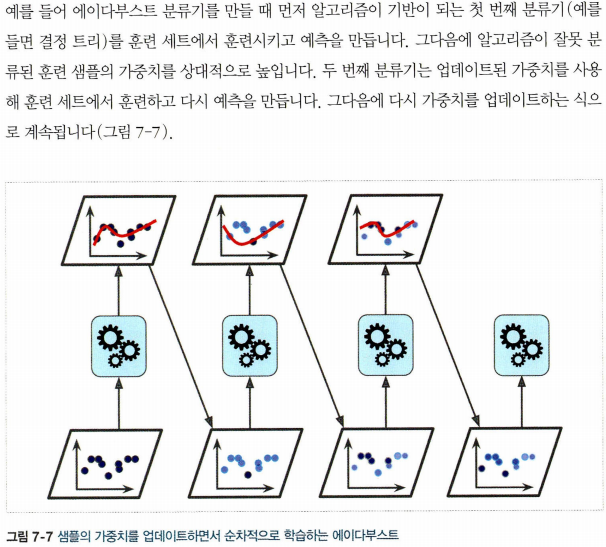

- 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만든다. 하지만 가중치가 적용된 훈련세트와 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.
---
- 연속된 학습 기법에는 중요한 단점이 하나 있다. 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화가 불가능하다. 따라서 배깅과 페이스팅만큰 확장성이 높지 않다

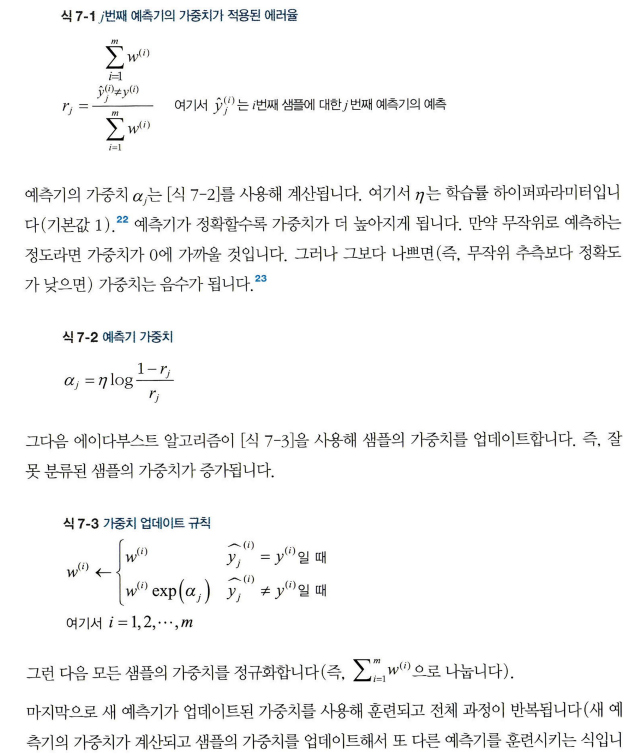

- 사이킷런은 에이다부스트의 다중 클래스 버전을 사용한다. 클래스가 2개뿐일때는 SAMME가 에이다부스트와 동일하다. 예측기가 클래스의 확률을 추정할 수 있다면(즉, predict_proba()메서드가 있다면) 사이킷런은 SAMME_R 이라는 SAMME의 변종을 사용한다. 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다
- 다음 코드는 사이킷런의 AdaBoostClassifier를 사용하여 200개의 아주 얕은 결정트리를 기반으로 하는 에이다부스트 분류기를 훈련시킨다. 여기에서 사용하는 결정 트리는 max_depth=1이다. 즉, 결정노드 하나와 리프노드 2개로 이루어진 트리이다. 이 트리가 AdaBoostClassifier의 기본 추정기이다.

In [64]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅
- 또다른 인기높은 부스팅 알고리즘은 그레이디언트 부스팅이다. 에이터부스트처럼 그레이디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다. 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여오차**에 새로운 예측기를 학습시킨다.
- 결정트리를 기반 예측기로 사용하는 간단한 회귀 문제를 풀어보자. 이를 **그레이디언트 트리 부스팅** 또는 **그레이디언트 부스티드 회귀 트리**라고 한다.
- DecisionTreeRegressor를 훈련세트에 학습시켜본다.

In [65]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [66]:
y2= y- tree_reg1.predict(X)  # 오차
tree_reg2 = DecisionTreeRegressor(max_depth=2)  # 오차에 대해 DT fit
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [67]:
y3= y2- tree_reg1.predict(X)  # 오차
tree_reg3 = DecisionTreeRegressor(max_depth=2)  # 오차에 대해 DT fit
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

- 이제 세개의 트리를 포함하는 앙상블 모델이 생겼다. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 된다.

In [70]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐을 알 수 있다.

- 사이킷런의 GradientBoostingRegressor를 사용하면 GBRT앙상블을 간단하게 훈련시킬 수 있다
- 다음은 이전의 절차와 같은 앙상블을 만드는 코드이다

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate 매개변수가 각 트리의 기여정도를 조절한다. learning_rate를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측성능이 좋아진다. 이는 **축소**라고 부르는 규제방식이다.
- 트리가 너무 많으면 과대적합될 수 있다. 최적의 트리 수를 찾기 위해 조기종료 기법을 사용할 수 있다. 이는 stged_predict()메서드를 통해 구현할 수 있다. 이 메서드는 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환한다.
- 다음 코드는 120개의 트리로 GMRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다. 마지막에 트리 수를 사용해 새로운 GBRT앙상블을 훈련시킨다.

In [72]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

- 왼쪽은 검증오차이고 오른쪽은 최적모델의 예측이다.

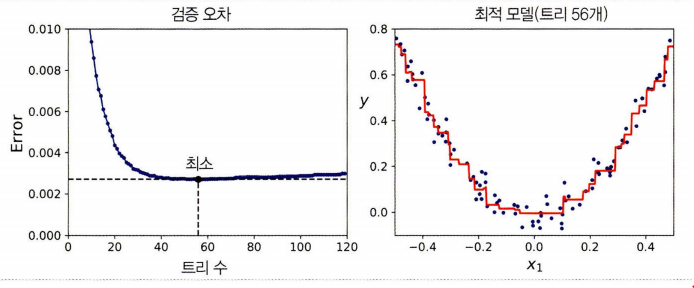

- 실제로 훈련을 중지하는 방법으로 조기종료를 구현할 수 있다. warm_start=True로 설정하면 사이킷런이 fit()메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다.
- 다음 코드는 연속해서 5번의 반복 동안 검증오차가 향상되지 않으면 훈련을 멈춘다.

In [73]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error= val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break  # 조기 종료

- 확률적 그레이디언트 부스팅(GradientBoosting) :각 트리가 훈련될 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원한다. 예를 들어 subsample=0.25 라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습된다. 편향이 높아지는 대신 분산이 낮아지게 된다. 또한 훈련속도를 상당히 높인다.
---
- 최적화된 그레이디언트 부스팅 구현으로 XGBoost 라이브러리가 유명하다.


In [74]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

- XGBoost는 자동 조기 종료와 같은 여러 좋은 기능도 제공한다

In [77]:
xgb_reg.fit(X_train,y_train,
            eval_set = [(X_val,y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.36527
[1]	validation_0-rmse:0.26412
[2]	validation_0-rmse:0.19120
[3]	validation_0-rmse:0.13860
[4]	validation_0-rmse:0.10060
[5]	validation_0-rmse:0.07256
[6]	validation_0-rmse:0.06333
[7]	validation_0-rmse:0.06089
[8]	validation_0-rmse:0.06190
[9]	validation_0-rmse:0.05788
[10]	validation_0-rmse:0.05628
[11]	validation_0-rmse:0.05535
[12]	validation_0-rmse:0.05455
[13]	validation_0-rmse:0.05421
[14]	validation_0-rmse:0.05419
[15]	validation_0-rmse:0.05417
[16]	validation_0-rmse:0.05428
[17]	validation_0-rmse:0.05432


## 7.6 스태킹
- 마지막 앙상블 모델은 **스태킹**이다. 이는 stacked generalization의 줄임말이다.

- 이는 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 모델을 훈련시킬수는 없을까? 라는 기본 아이디어로 출발한다. 아래의 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(**블렌더** 또는 **메타 학습기**라고 한다.) 이 예측을 입력으로 받아 최종 예측을 만든다.

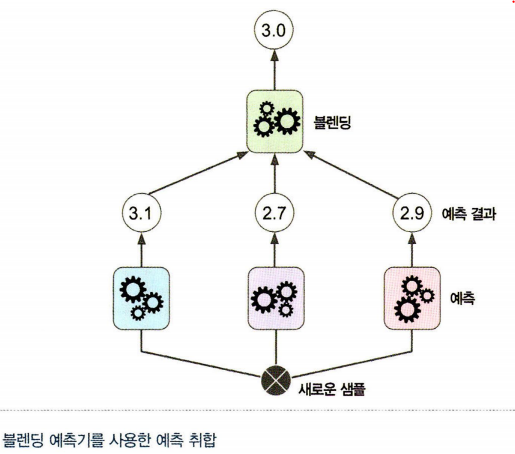

- 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것이다.
- 일단 훈련세트를 두개의 서브셋으로 나눈 뒤 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용된다.

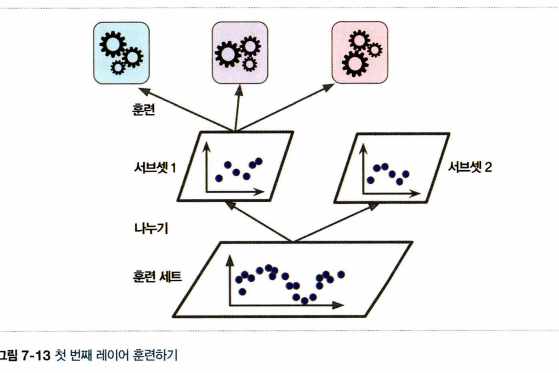
- 그런 다음 첫번째 레이어의 예측기를 사용해 두번째 홀드아웃세트에 대한 예측을 만든다. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것이다. 홀드아웃세트의 각 샘플에 대해 세개의 예측값이 있다. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트(3차원)를 만들 수 있다. 블렌더가 새 훈련 세트로 훈련된다. 즉, 첫번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습된다.

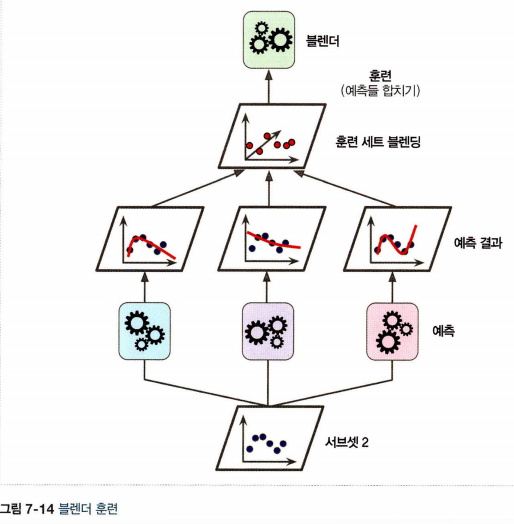

- 이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능하다. 그러면 블렌더만의 레이어가 만들어지게 왼다. 이렇게 하려면 훈련 세트를 세개의 서브셋으로 나눈다. 첫번째 세트는 첫번째 레이어를 훈련시키는데 사용되고 두번째 세트는 두번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용된다. 그리고 세번째 세트는 세번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용된다. 작업이 끝나면 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있다.

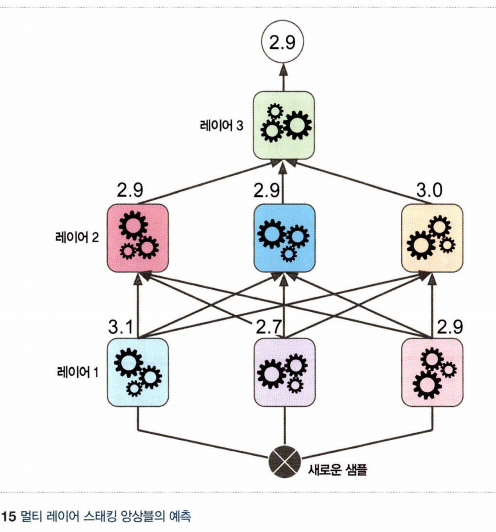